# MMM-Oxford 2x2 SARS-CoV-2 truth set

Comparing SARS2-positive samples from a mixture of cultured and high Ct OUH clinical samples using combinations of:
1. Nanopore and Illumina sequencing
2. ARTIC v3 amplicon sequencing and SISPA whole genome amplification

There are three subsets for testing purposes:
1. **`core`** subset of 12(x4) samples with high coverage sequences representing all amplification and platform combinations
2. **`lineage`** subset of 25(x2) lineage-distinct samples with high coverage ARTIC v3 (ONT and Illumina) representation
3. **`repro`** subset of 10(x2) ONT samples in duplicate and 11(x2) Illumina samples in duplicate with high coverage ARTIC v3 representation

---

## Notes

### Field descriptions

- `name`: Primary identifier comprising `class_`, `sample` and `replicate`
- `class_`: Concatenation of organisation, `amplification` method and sequencing `platform`
    - `{'mmm-artic-ill', 'mmm-artic-ont', 'mmm-sispa-ill', 'mmm-sispa-ont', 'phe-sispa-ill', 'phe-sispa-ont'}`
- `sample`: Truncated SHA1 digest of the original identifying sample name/accession
    - `'s' + str(int(hashlib.sha1(x.encode()).hexdigest(), 16)).str[:6]`
- `replicate`: Replicate of a given `sample`-`platform`-`amplification` combination
- `origin`: Whether derived from tissue culture or a clinical specimen
    - `{'culture', 'clinical'}`
- `amplification`: Amplification methodology
    - `{'artic', 'sispa'}`
- `platform`: Sequencing platform
    - `{'ont', 'ill'}`
- `fastq_filename`: Fastq filename(s) globbed with asterisk. One for ONT, two for Illumina samples:
    - Oxford Nanopore (`platform == 'ont'`)
        - `{name}.fastq.gz` (e.g. `mmm-artic-ont-s10370-1.fastq.gz`)
    - Illumina (`platform == 'ill'`):
        - `{name}_1.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_1.fastq.gz`)
        - `{name}_2.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_2.fastq.gz`)
- `oci_bucket`: Parent bucket in the Oracle Cloud SP3 tenancy

### FASTQ locations
- OCI bucket: `SARS-CoV-2_reference_ox`
- MMM `analysis1`: `/home/ndm.local/bede/covid/truth/fastq_dehosted/`

## Sequencing
- Illumina: MiSeq, 2x250bp
- ONT: GridION, R9.4.1

### QC

- ONT sequences basecalled with Guppy 4.2.3 (HAC)
- Human sequences (`taxid == 9606`) removed using kraken2 2.1.2 and [Standard-16](https://benlangmead.github.io/aws-indexes/k2)
- `cov20_pc` and `median_depth` calculated from minimap2+samtools depths output using reference `MN908947.3`  

### GPAS Comparison

- Viridian and ARTIC protocols for ONT & Illumina
- Pangolin version: 3.1.7
- Nextclade version: ?

### Caveats

- Viridian to be rerun for SISPA with `--wgs`
- No delta
- 100bp Illumina samples to be investigated
- Some samples, generally SISPA have poor coverage
- Currently fastq only, however Nanopore fast5s are available
- Some erratic indel calling from GPAS Nextclade of unknown version

### Todo

- [x] Create core 2x2 subset
- [x] Join GPAS Viridian and ARTIC outputs
- [ ] Between-pipeline comparison
    - [ ] Rerun Viridian with `--wgs` flag
- [ ] Within-sample comparison
- [ ] Between amplification and between-platform comparison
- [ ] Curate references

In [1]:
import collections
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('mmm-2x2-truth.2021-07-16.csv').drop(['pangolin_lineage', 'pangolin_version'], axis=1)
# df = pd.read_csv('mmm-2x2-truth.2021-07-16.csv')
df['oci_bucket'] = 'SARS-CoV-2_reference_ox'

print(f'Length: {df.shape[0]}')
df.head(1)

Length: 309


,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,oci_bucket
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,SARS-CoV-2_reference_ox


## GPAS outputs for comparison

- Uses outputs from GPAS
    - Viridian
    - ARTIC-based pipelies
        - ONT: Medaka
        - Illumina: Connor lab pipeline (COG)
- Ignores otherwise duplicated records enumerating aln2type types

In [3]:
analysis_report_fields = ['name', 'totalMissing', 'variant_caller', 'lineage', 'scorpio_call', 'clade', 'pangolin_version', 'substitutions', 'insertions', 'deletions', 'aaSubstitutions', 'aaDeletions']

anal_vir_ill_df = pd.read_csv('res/2x2-ill-viridian.9160f2aa-c89a-4f26-add2-7fd1c8739303/analysis/report/illumina/analysisReport.tsv', sep='\t').drop_duplicates('sample name')
anal_vir_ont_df = pd.read_csv('res/2x2-ont-viridian.969b01b0-7a7e-4966-bece-bd13c2319af1/analysis/report/nanopore/analysisReport.tsv', sep='\t').drop_duplicates('sample name')
anal_vir_df = (pd.concat([anal_vir_ont_df, anal_vir_ill_df])
               .assign(variant_caller='viridian')
               .rename({'sample name': 'name'}, axis=1)
               [[*analysis_report_fields]]
               .set_index('name'))

anal_cog_ill_df = pd.read_csv('res/2x2-ill-cog.350d9085-b45d-4849-9d80-47e31c7e70fe/analysis/report/illumina/analysisReport.tsv', sep='\t').drop_duplicates('sample name').assign(variant_caller='cog')
anal_med_ill_df = pd.read_csv('res/2x2-ont-medaka.d058b11c-3fa0-43e5-aef0-3e5e6591ac1a/analysis/report/nanopore/analysisReport.tsv', sep='\t').drop_duplicates('sample name').assign(variant_caller='cog')
anal_art_df = (pd.concat([anal_med_ill_df, anal_cog_ill_df])
               .rename({'sample name': 'name'}, axis=1)
               [[*analysis_report_fields]]
               .set_index('name'))

comp_columns = ['totalMissing', 'lineage', 'scorpio_call', 'clade', 'substitutions', 'deletions', 'insertions', 'aaSubstitutions', 'aaDeletions']
comp_df = (anal_art_df[[*comp_columns]]
           .rename({c:f'art_{c}' for c in comp_columns}, axis=1)
           .join(anal_vir_df[[*comp_columns]]
           .rename({c:f'vir_{c}' for c in comp_columns}, axis=1))
           .replace('None', np.nan).copy())  # Replace Pangolin None lineage calls with NaNs

meta_df = df.join(comp_df, how='inner', on='name')  # Keep only rows with GPAS output
meta_df.to_csv('meta.csv', index=False)
meta_df.shape

(286, 29)

In [4]:
meta_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,...,art_aaDeletions,vir_totalMissing,vir_lineage,vir_scorpio_call,vir_clade,vir_substitutions,vir_deletions,vir_insertions,vir_aaSubstitutions,vir_aaDeletions
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,...,"ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",0.0,P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,28269:AAAC,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"


## Lineage distribution

<AxesSubplot:>

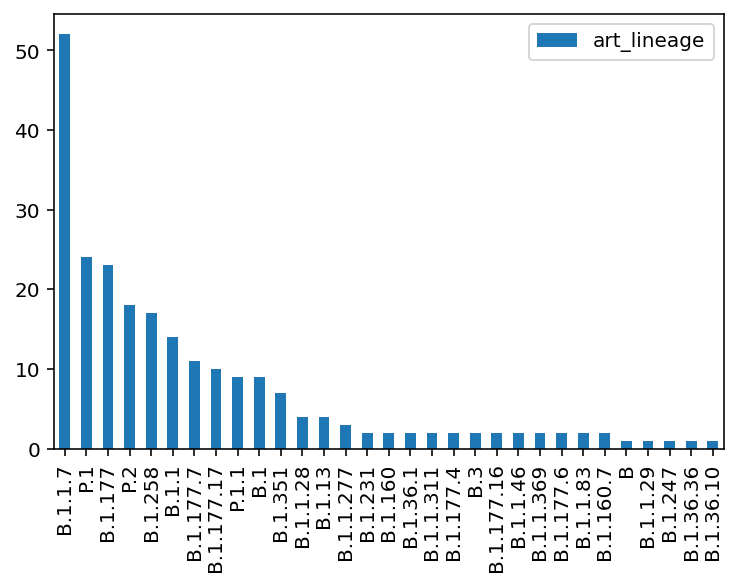

In [5]:
meta_df.art_lineage.value_counts().to_frame().plot.bar()

## 1. `core` 2x2 testing subset
- 12 samples sequenced with *high coverage* ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina
- Provided as 4 CSVs with 12 rows each:
    - `testset-core-artic-ont.csv`
    - `testset-core-artic-ill.csv`
    - `testset-core-sispa-ont.csv`
    - `testset-core-sispa-ill.csv`

In [6]:
# ARTIC-ONT + ARTIC-Illumina and >= 95% cov20 
artic_both_platforms_95_df = (df.query("amplification == 'artic' and cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['platform']
 .to_frame()
 .query("platform == 2"))
artic_both_platforms_95_df
print(artic_both_platforms_95_df.index.nunique(), 'samples with high coverage ARTIC-ONT and ARTIC-Illumina data')

# 2x2 samples exist
twobytwo_df = (df.groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_df.index.nunique(), 'samples with ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data')

# 2x2 samples exist and >= 95% cov20
twobytwo_95_df = (df.query("cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_95_df.index.nunique(), 'samples with high coverage ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data')

twobytwo_95_samples = twobytwo_95_df.index

core_subset_art_ont_df = meta_df.query("cov20_pc >= 95 and amplification == 'artic' and platform == 'ont' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_art_ill_df = meta_df.query("cov20_pc >= 95 and amplification == 'artic' and platform == 'ill' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_sis_ont_df = meta_df.query("cov20_pc >= 95 and amplification == 'sispa' and platform == 'ont' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_sis_ill_df = meta_df.query("cov20_pc >= 95 and amplification == 'sispa' and platform == 'ill' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_df = pd.concat([core_subset_art_ont_df, core_subset_art_ill_df, core_subset_sis_ont_df, core_subset_sis_ill_df])
core_subset_names = set(core_subset_df.name)

core_subset_art_ont_df.to_csv('testset-core-artic-ont.csv', index=False)
core_subset_art_ill_df.to_csv('testset-core-artic-ill.csv', index=False)
core_subset_sis_ont_df.to_csv('testset-core-sispa-ont.csv', index=False)
core_subset_sis_ill_df.to_csv('testset-core-sispa-ill.csv', index=False)

core_subset_art_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-artic-ont.csv', header=False, index=False)
core_subset_art_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-artic-ill.csv', header=False, index=False)
core_subset_sis_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-sispa-ont.csv', header=False, index=False)
core_subset_sis_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-sispa-ill.csv', header=False, index=False)
print(core_subset_df.columns)

52 samples with high coverage ARTIC-ONT and ARTIC-Illumina data
23 samples with ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data
12 samples with high coverage ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_totalMissing', 'art_lineage', 'art_scorpio_call', 'art_clade',
       'art_substitutions', 'art_deletions', 'art_insertions',
       'art_aaSubstitutions', 'art_aaDeletions', 'vir_totalMissing',
       'vir_lineage', 'vir_scorpio_call', 'vir_clade', 'vir_substitutions',
       'vir_deletions', 'vir_insertions', 'vir_aaSubstitutions',
       'vir_aaDeletions'],
      dtype='object')


## 2. `lineage`: between-platform ARTIC v3 testing subset

- **25 ARTIC samples with matched ONT + Illumina**
- Distinct lineages
- Matching ONT+Illumina pairs identified by `matched_pair`
- `cov20_pc > 95`
- `lineage` is not `NaN`
- Now frozen into (`sp3-testset-lineage-ont.csv` and `sp3-testset-lineage-ill.csv`)

In [7]:
lineage_subset_ont_names = set(pd.read_csv('sp3-testset-lineage-ont.csv', header=None, usecols=[1]).squeeze())
lineage_subset_ill_names = set(pd.read_csv('sp3-testset-lineage-ill.csv', header=None, usecols=[1]).squeeze())

lineage_subset_ont_df = meta_df.query("name in @lineage_subset_ont_names").sort_values('sample').reset_index(drop=True).fillna('')
lineage_subset_ill_df = meta_df.query("name in @lineage_subset_ill_names").sort_values('sample').reset_index(drop=True).fillna('')

lineage_subset_ont_df.index.rename('matched_pair', inplace=True)
lineage_subset_ill_df.index.rename('matched_pair', inplace=True)
lineage_subset_df = pd.concat([lineage_subset_ont_df, lineage_subset_ill_df])
lineage_subset_names = set(lineage_subset_df.name)

lineage_subset_ont_df.to_csv('testset-lineage-ont.csv')
lineage_subset_ill_df.to_csv('testset-lineage-ill.csv')

print(lineage_subset_ont_df.shape[0], lineage_subset_ill_df.shape[0])
print(lineage_subset_df.columns)

25 25
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_totalMissing', 'art_lineage', 'art_scorpio_call', 'art_clade',
       'art_substitutions', 'art_deletions', 'art_insertions',
       'art_aaSubstitutions', 'art_aaDeletions', 'vir_totalMissing',
       'vir_lineage', 'vir_scorpio_call', 'vir_clade', 'vir_substitutions',
       'vir_deletions', 'vir_insertions', 'vir_aaSubstitutions',
       'vir_aaDeletions'],
      dtype='object')


## 3. `repro`: within-platform ARTIC v3 testing subset

- **10 samples x 2 replicates (ONT)**
- **11 samples x 2 replicates (Illumina)**
- Distinct lineages
- Matched within-platform pairs denoted by `matched_pair` field
- `cov20_pc > 95`
- `lineage` is not `NaN`
- Now frozen into (`sp3-testset-repro-ont.csv` and `sp3-testset-repro-ill.csv`)

In [8]:
repro_subset_ont_names = set(pd.read_csv('sp3-testset-repro-ont.csv', header=None, usecols=[1]).squeeze())
repro_subset_ill_names = set(pd.read_csv('sp3-testset-repro-ill.csv', header=None, usecols=[1]).squeeze())

repro_subset_ont_df = meta_df.query("name in @repro_subset_ont_names").sort_values('sample').reset_index(drop=True).fillna('')
repro_subset_ill_df = meta_df.query("name in @repro_subset_ill_names").sort_values('sample').reset_index(drop=True).fillna('')

repro_subset_ont_df.index.rename('matched_pair', inplace=True)
repro_subset_ill_df.index.rename('matched_pair', inplace=True)
repro_subset_df = pd.concat([repro_subset_ont_df, repro_subset_ill_df])
repro_subset_names = set(repro_subset_df.name)

repro_subset_ont_df.to_csv(f'testset-repro-ont.csv')
repro_subset_ill_df.to_csv(f'testset-repro-ill.csv')

print(repro_subset_ont_df.shape[0], repro_subset_ill_df.shape[0])
print(repro_subset_df.columns)

20 22
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_totalMissing', 'art_lineage', 'art_scorpio_call', 'art_clade',
       'art_substitutions', 'art_deletions', 'art_insertions',
       'art_aaSubstitutions', 'art_aaDeletions', 'vir_totalMissing',
       'vir_lineage', 'vir_scorpio_call', 'vir_clade', 'vir_substitutions',
       'vir_deletions', 'vir_insertions', 'vir_aaSubstitutions',
       'vir_aaDeletions'],
      dtype='object')


## Between-pipeline conflict
### Everything

In [9]:
tmp_df = meta_df[['name', 'sample', 'amplification', 'platform', 'cov20_pc', 'art_totalMissing', 'vir_totalMissing', 'art_lineage', 'vir_lineage', 'art_substitutions', 'vir_substitutions', 'art_deletions', 'vir_deletions', 'art_insertions', 'vir_insertions']].copy()

names_conflict_lineage = {}
names_conflict_sub = {}
names_conflict_del = {}
names_conflict_ins = {}

for r in tmp_df.fillna('').to_dict('records'):
    art_lineage = set(r['art_lineage'].split(','))
    vir_lineage = set(r['vir_lineage'].split(','))
    art_sub = set(r['art_substitutions'].split(','))
    vir_sub = set(r['vir_substitutions'].split(','))
    art_del = set(r['art_deletions'].split(','))
    vir_del = set(r['vir_deletions'].split(','))
    art_ins = set(r['art_insertions'].split(','))
    vir_ins = set(r['vir_insertions'].split(','))
    names_conflict_lineage[r['name']] = ','.join(filter(None, art_lineage^vir_lineage))  # Filter removes empty strings
    names_conflict_sub[r['name']] = ','.join(filter(None, art_sub^vir_sub))  # Filter removes empty strings
    names_conflict_del[r['name']] = ','.join(filter(None, art_del^vir_del))  # Filter removes empty strings
    names_conflict_ins[r['name']] = ','.join(filter(None, art_ins^vir_ins))  # Filter removes empty strings

tmp_df['conflicting_lineages'] = tmp_df['name'].map(names_conflict_lineage)
tmp_df['conflicting_substitutions'] = tmp_df['name'].map(names_conflict_sub)
tmp_df['conflicting_deletions'] = tmp_df['name'].map(names_conflict_del)
tmp_df['conflicting_insertions'] = tmp_df['name'].map(names_conflict_ins)
tmp_df.fillna('', inplace=True)

# between_pipeline_conflicts_df = tmp_df[['name', 'origin', 'cov20_pc', 'conflicting_lineages', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']].copy()
between_pipeline_conflicts_df = tmp_df.copy()
print(between_pipeline_conflicts_df.shape[0])
between_pipeline_conflicts_df.head(1)

286


,name,sample,amplification,platform,cov20_pc,art_totalMissing,vir_totalMissing,art_lineage,vir_lineage,art_substitutions,vir_substitutions,art_deletions,vir_deletions,art_insertions,vir_insertions,conflicting_lineages,conflicting_substitutions,conflicting_deletions,conflicting_insertions
0,mmm-artic-ill-s24350-1,s24350,artic,ill,99.771689,89.0,0.0,P.1,P.1,"C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,11288-11297,28269:AAAC,28269:AAAC,,,,


In [10]:
print(between_pipeline_conflicts_df.query("conflicting_lineages != ''").shape[0],
      between_pipeline_conflicts_df.query("conflicting_substitutions != ''").shape[0],
      between_pipeline_conflicts_df.query("conflicting_deletions != ''").shape[0],
      between_pipeline_conflicts_df.query("conflicting_insertions != ''").shape[0])

45 117 91 28


### `core` subset
#### Lineages

In [11]:
core_subset_df.query("vir_lineage != art_lineage")[['name', 'sample', 'cov20_pc', 'art_totalMissing', 'vir_totalMissing', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']].sort_values('sample')

,name,sample,cov20_pc,art_totalMissing,vir_totalMissing,art_lineage,vir_lineage,art_clade,vir_clade
260,mmm-sispa-ont-s11511-2,s11511,100.000000,1338.0,24127.0,B.1.177,NaN,20E (EU1),20A
171,mmm-sispa-ont-s12220-1,s12220,100.000000,528.0,24088.0,B.1.177.7,NaN,20E (EU1),20A
9,mmm-sispa-ont-s24350-1,s24350,100.000000,1671.0,22457.0,P.1,NaN,"20J (Gamma, V3)","20J (Gamma, V3)"
68,mmm-sispa-ont-s32219-2,s32219,100.000000,1918.0,22582.0,B.1.351,NaN,"20H (Beta, V2)","20H (Beta, V2)"
275,mmm-sispa-ont-s53667-1,s53667,100.000000,470.0,17249.0,B.1.258,NaN,20A,20A
20,mmm-sispa-ill-s59130-3,s59130,99.989927,0.0,0.0,P.1,P.1.1,"20J (Gamma, V3)","20J (Gamma, V3)"
216,mmm-sispa-ont-s71898-2,s71898,100.000000,7870.0,0.0,B.1,A,20E (EU1),19A
27,mmm-artic-ont-s98244-1,s98244,100.000000,123.0,0.0,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"
26,mmm-artic-ill-s98244-3,s98244,99.909347,74.0,0.0,P.1,P.1.1,"20J (Gamma, V3)","20J (Gamma, V3)"
35,mmm-sispa-ont-s98244-3,s98244,100.000000,124.0,3412.0,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"


#### Variants

In [12]:
(between_pipeline_conflicts_df
 .query("name in @core_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'art_totalMissing', 'vir_totalMissing', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']])

,name,cov20_pc,art_totalMissing,vir_totalMissing,conflicting_substitutions,conflicting_deletions,conflicting_insertions
2,mmm-artic-ill-s24350-3,99.969782,71.0,0.0,,,28269:AAAC
3,mmm-artic-ont-s24350-1,100.000000,122.0,0.0,T29834A,11082,
6,mmm-sispa-ill-s24350-1,100.000000,0.0,0.0,T29858A,,
9,mmm-sispa-ont-s24350-1,100.000000,1671.0,22457.0,"A23063T,A5648C,C24642T,A6319G,A23403G,G25088T,...","1633,11288-11292,11293-11297",
15,mmm-artic-ont-s59130-1,100.000000,122.0,0.0,T29834A,,28269:AAAC
20,mmm-sispa-ill-s59130-3,99.989927,0.0,0.0,T29858A,,28269:AAAC
23,mmm-sispa-ont-s59130-3,100.000000,135.0,6056.0,"T14552G,C21614T,T29834A,G25088T,C14408T,C3037T...","11082,11288-11297",
26,mmm-artic-ill-s98244-3,99.909347,74.0,0.0,G11401T,,
27,mmm-artic-ont-s98244-1,100.000000,123.0,0.0,"G11401T,T29834A",11082,
30,mmm-sispa-ill-s98244-1,99.993285,0.0,0.0,"G11401T,T29858A",,28269:AAAC


### `lineage` subset
#### Lineages

In [13]:
# between_pipeline_conflicts_df.query("name in @lineage_subset_names and conflicting_lineages != ''")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage']]
lineage_subset_df.query("vir_lineage != art_lineage and vir_lineage != 'None' and art_lineage != 'None'")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']]

,name,origin,cov20_pc,art_lineage,vir_lineage,art_clade,vir_clade
matched_pair,,,,,,,
6,mmm-artic-ont-s12152-1,clinical,99.959710,B.1.1,B.1.1.277,20B,20B
11,mmm-artic-ont-s14131-1,clinical,100.000000,B,B.1.36.10,19A,19A
11,mmm-artic-ill-s14131-1,clinical,98.784582,B.1.36.10,B,19A,19A


#### Variants

In [14]:
(between_pipeline_conflicts_df
 .query("name in @lineage_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']])

,name,cov20_pc,conflicting_substitutions,conflicting_deletions,conflicting_insertions
1,mmm-artic-ill-s24350-2,99.969782,,,28269:AAAC
3,mmm-artic-ont-s24350-1,100.000000,T29834A,11082,
13,mmm-artic-ill-s59130-2,99.909347,,,28269:AAAC
15,mmm-artic-ont-s59130-1,100.000000,T29834A,,28269:AAAC
65,mmm-artic-ont-s32219-1,99.462799,,11082,
87,mmm-artic-ont-s14305-1,100.000000,,11082,
89,mmm-artic-ont-s99011-1,100.000000,,11082,
91,mmm-artic-ont-s12466-1,100.000000,,11082,
93,mmm-artic-ont-s10370-1,100.000000,C21575T,"11082,21575",
97,mmm-artic-ont-s60021-1,100.000000,,11082,


### `repro` subset
#### Lineages

In [15]:
repro_subset_df.query("vir_lineage != art_lineage and vir_lineage != 'None' and art_lineage != 'None'")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']]

,name,origin,cov20_pc,art_lineage,vir_lineage,art_clade,vir_clade
matched_pair,,,,,,,
5,mmm-artic-ont-s12152-1,clinical,99.95971,B.1.1,B.1.1.277,20B,20B
16,mmm-artic-ont-s59130-2,culture,100.00000,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"


#### Variants

In [16]:
(between_pipeline_conflicts_df
 .query("name in @repro_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']]).sort_values('name')

,name,cov20_pc,conflicting_substitutions,conflicting_deletions,conflicting_insertions
85,mmm-artic-ill-s14305-2,96.813725,T17007C,,
1,mmm-artic-ill-s24350-2,99.969782,,,28269:AAAC
2,mmm-artic-ill-s24350-3,99.969782,,,28269:AAAC
267,mmm-artic-ill-s53667-1,99.486301,C22879A,,
13,mmm-artic-ill-s59130-2,99.909347,,,28269:AAAC
207,mmm-artic-ill-s71898-1,100.000000,"C29696A,G29688A",,
254,mmm-artic-ont-s11511-2,100.000000,,11082,
77,mmm-artic-ont-s12142-2,100.000000,,11082,
134,mmm-artic-ont-s12152-1,99.959710,"C6445T,G28881A,G28883C,G6352T,G28882A,T10722C,...",11082,
135,mmm-artic-ont-s12152-2,99.560167,,21639,


## Within-sample conflict
### `core` subset

In [17]:
core_subset_df.set_index(['sample', 'amplification', 'platform']).sort_index()

name         class_  \
sample amplification platform                                          
s11511 artic         ill       mmm-artic-ill-s11511-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s11511-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s11511-2  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s11511-2  mmm-sispa-ont   
s12220 artic         ill       mmm-artic-ill-s12220-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s12220-4  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s12220-2  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s12220-1  mmm-sispa-ont   
s12368 artic         ill       mmm-artic-ill-s12368-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s12368-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s12368-2  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s12368-3  mmm-sispa-ont   
s16621 artic         ill       mmm-artic-ill-s16621-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s16621-3  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s16621-1  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s16621-2  mmm-sispa-ont   
s24350 artic         ill       mmm-artic-ill-s24350-3  mmm-artic-ill   
                     ont       mmm-artic-ont-s24350-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s24350-1  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s24350-1  mmm-sispa-ont   
s32219 artic         ill       mmm-artic-ill-s32219-2  mmm-artic-ill   
                     ont       mmm-artic-ont-s32219-1  mmm-artic-ont   
       sispa         ill       phe-sispa-ill-s32219-1  phe-sispa-ill   
                     ont       mmm-sispa-ont-s32219-2  mmm-sispa-ont   
s53667 artic         ill       mmm-artic-ill-s53667-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s53667-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s53667-2  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s53667-1  mmm-sispa-ont   
s59130 artic         ill       mmm-artic-ill-s59130-3  mmm-artic-ill   
                     ont       mmm-artic-ont-s59130-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s59130-3  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s59130-3  mmm-sispa-ont   
s64379 artic         ill       mmm-artic-ill-s64379-3  mmm-artic-ill   
                     ont       mmm-artic-ont-s64379-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s64379-3  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s64379-3  mmm-sispa-ont   
s71898 artic         ill       mmm-artic-ill-s71898-2  mmm-artic-ill   
                     ont       mmm-artic-ont-s71898-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s71898-1  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s71898-2  mmm-sispa-ont   
s82718 artic         ill       mmm-artic-ill-s82718-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s82718-2  mmm-artic-ont   
       sispa         ill       phe-sispa-ill-s82718-1  phe-sispa-ill   
                     ont       phe-sispa-ont-s82718-1  phe-sispa-ont   
s98244 artic         ill       mmm-artic-ill-s98244-3  mmm-artic-ill   
                     ont       mmm-artic-ont-s98244-1  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s98244-1  mmm-sispa-ill   
                     ont       mmm-sispa-ont-s98244-3  mmm-sispa-ont   

                                 origin  replicate  \
sample amplification platform                        
s11511 artic         ill       clinical          1   
                     ont       clinical          1   
       sispa         ill       clinical          2   
                     ont       clinical          2   
s12220 artic         ill       clinical          1   
                     ont       clinical          4   
       sispa    

#### Lineages

In [18]:
core_subset_df.groupby('sample')['art_lineage'].describe().join(core_subset_df.groupby('sample').agg(set)['art_lineage'].rename('distinct'))

,count,unique,top,freq,distinct
sample,,,,,
s11511,4,1,B.1.177,4,{B.1.177}
s12220,4,1,B.1.177.7,4,{B.1.177.7}
s12368,4,2,P.2,3,"{P.2, B.1.1.28}"
s16621,4,1,B.1.1.7,4,{B.1.1.7}
s24350,4,1,P.1,4,{P.1}
s32219,4,1,B.1.351,4,{B.1.351}
s53667,4,1,B.1.258,4,{B.1.258}
s59130,4,2,P.1,2,"{P.1, P.1.1}"
s64379,4,1,P.2,4,{P.2}


#### Variants

In [19]:
def conflicts_from_meta(subset_df):
    var_types = ['substitutions', 'deletions', 'insertions', 'aaSubstitutions', 'aaDeletions']
    types_conflicts = dict.fromkeys(var_types, )
    types_conflicts = collections.defaultdict(dict)

    for sample in subset_df['sample'].unique():
        for var_type in var_types:
            result = subset_df.fillna('').query(f"sample == '{sample}'")[f'art_{var_type}'].tolist()
            setlist = [set(i.split(',')) for i in result]
            union = set.union(*setlist)
            intersection = set.intersection(*setlist)
            conflicting_variants = list(filter(None, union-intersection))  # Filter removes empty strings 
            types_conflicts[var_type][sample] = ','.join(conflicting_variants) if conflicting_variants else ''

    tmp_df = subset_df[['sample']].drop_duplicates('sample').set_index('sample')
    tmp_df['conflicting_substitutions'] = tmp_df.index.map(types_conflicts['substitutions'])
    tmp_df['conflicting_deletions'] = tmp_df.index.map(types_conflicts['deletions'])
    tmp_df['conflicting_insertions'] = tmp_df.index.map(types_conflicts['insertions'])
    tmp_df['conflicting_aaDeletions'] = tmp_df.index.map(types_conflicts['aaDeletions'])
    tmp_df['conflicting_aaSubstitutions'] = tmp_df.index.map(types_conflicts['aaSubstitutions'])
    return tmp_df

core_conflicts_art_df = conflicts_from_meta(core_subset_df)
core_conflicts_art_nosispa_df = conflicts_from_meta(core_subset_df.query("amplification != 'sispa'"))

In [20]:
core_conflicts_art_df

,conflicting_substitutions,conflicting_deletions,conflicting_insertions,conflicting_aaDeletions,conflicting_aaSubstitutions
sample,,,,,
s11511,,,,,
s12220,"C44T,T2C",,,,
s12368,"G28975T,G28628T,C28253T",,,,"N:M234I,N:A119S"
s16621,,,,,
s24350,"C21614T,T29858A,C2749T,A22812C,C11454T,C21621A...","11288-11292,11288-11297,11293-11297",28269:AAAC,ORF1a:G3676-,"S:K417T,ORF1a:A3730V,ORF1a:G3676X,S:T20N,S:L18F"
s32219,"A23063T,G5230T,C25904T,G23012A",,,,"S:N501Y,S:E484K,ORF3a:S171L,ORF1a:K1655N"
s53667,,,,,
s59130,"C21614T,T29858A,C2749T,C21621A,T29834A",11288-11297,28269:AAAC,"ORF1a:F3677-,ORF1a:G3676-,ORF1a:S3675-","S:L18F,S:T20N"
s64379,G28628T,,,,N:A119S


In [21]:
core_conflicts_art_nosispa_df

,conflicting_substitutions,conflicting_deletions,conflicting_insertions,conflicting_aaDeletions,conflicting_aaSubstitutions
sample,,,,,
s11511,,,,,
s12220,,,,,
s12368,,,,,
s16621,,,,,
s24350,T29834A,,28269:AAAC,,
s32219,"A23063T,G23012A",,,,"S:N501Y,S:E484K"
s53667,,,,,
s59130,T29834A,,28269:AAAC,,
s64379,,,,,


In [22]:
# Single sample scrutiny
core_subset_df.query("not (amplification == 'sispa' and platform == 'ont') and sample == 's12220'").set_index(['sample', 'amplification', 'platform']).sort_index()

name         class_  \
sample amplification platform                                          
s12220 artic         ill       mmm-artic-ill-s12220-1  mmm-artic-ill   
                     ont       mmm-artic-ont-s12220-4  mmm-artic-ont   
       sispa         ill       mmm-sispa-ill-s12220-2  mmm-sispa-ill   

                                 origin  replicate  \
sample amplification platform                        
s12220 artic         ill       clinical          1   
                     ont       clinical          4   
       sispa         ill       clinical          2   

                                                 fastq_filename    cov20_pc  \
sample amplification platform                                                 
s12220 artic         ill       mmm-artic-ill-s12220-1*.fastq.gz   99.858985   
                     ont       mmm-artic-ont-s12220-4*.fastq.gz  100.000000   
       sispa         ill       mmm-sispa-ill-s12220-2*.fastq.gz  100.000000   

                               median_depth               oci_bucket  \
sample amplification platform                                          
s12220 artic         ill               5116  SARS-CoV-2_reference_ox   
                     ont               2584  SARS-CoV-2_reference_ox   
       sispa         ill               1132  SARS-CoV-2_reference_ox   

                               art_totalMissing art_lineage  ...  \
sample amplification platform                                ...   
s12220 artic         ill                   71.0   B.1.177.7  ...   
                     ont                  121.0   B.1.177.7  ...   
       sispa         ill                   67.0   B.1.177.7  ...   

                              art_aaDeletions vir_totalMissing vir_lineage  \
sample amplification platform                                                
s12220 artic         ill                  NaN            236.0   B.1.177.7   
                     ont                  NaN              0.0   B.1.177.7   
       sispa         ill                  NaN              0.0   B.1.177.7   

                              vir_scorpio_call  vir_clade  \
sample amplification platform                               
s12220 artic         ill                   NaN  20E (EU1)   
                     ont                   NaN  20E (EU1)   
       sispa         ill                   NaN  20E (EU1)   

                                                               vir_substitutions  \
sample amplification platform                                                      
s12220 artic         ill       G204T,C241T,T445C,C1625T,C3037T,G4454T,C6286T,...   
                     ont       G204T,C241T,T445C,C1625T,C3037T,G4454T,C6286T,...   
       sispa         ill       C44T,G204T,C241T,T445C,C1625T,C3037T,G4454T,C6...   

                              vir_deletions  vir_insertions  \
sample amplification platform                                 
s12220 artic         ill                NaN             NaN   
                     ont                NaN             NaN   
       sispa         ill                NaN             NaN   

                                                             vir_aaSubstitutions  \
sample amplification platform                                                      
s12220 artic         ill       N:A220V,ORF1a:L454F,ORF1a:A1397S,ORF1b:P314L,S...   
                     ont       N:A220V,ORF1a:L454F,ORF1a:A1397S,ORF1b:P314L,S...   
       sispa         ill       N:A220V,ORF1a:L454F,ORF1a:A1397S,ORF1b:P314L,S...   

                              vir_aaDeletions  
sample amplification platform                  
s12220 artic         ill                  NaN  
                     ont                  NaN  
       sispa         ill                  NaN  

[3 rows x 26 columns]